In [8]:
from math import inf
from copy import deepcopy
import random
import time
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

## Utilities

`Logger`, for printable messages that can be turned on and off.

In [5]:
class Logger:
    def __init__(self):
        self.on = True
    def log(*args, **kwargs):
        self = args[0]
        if self.on:
            print(*args[1:], **kwargs)

logger = Logger()
logger.log('This will be printed')
logger.on = False
logger.log('This will not be printed')
logger.on = True
logger.log('This will be printed too')


This will be printed
This will be printed too


In [6]:
def path_str(path: list) -> str:
    return ' → '.join([node.name for node in path])

## Graph Data Structures

### Node

In [7]:
class Node:
    def __init__(self, name : str, graph, distance=inf):
        self.name = str(name).upper()
        self.distance = distance
        self.visited = False
        # Store graph so it can find edges that connect self
        self.graph = graph
        self.shortest_path_prev_node = None
    def __str__(self):
        if self.distance == inf:
            name =  f'Node({self.name})'
        else:
            name = f'Node({self.name}, d={self.distance})'
        # Colored Red if node is visited
        if self.visited:
            name = f'\033[92m{name}\033[0m'
        # Colored cyan if node isn't visited but distance < ∞
        elif self.distance != inf:
            name = f'\033[96m{name}\033[0m'
        return name
    def __repr__(self):
        return self.__str__()
    def edges(self, no_visited_nodes=True):
        connecting_edges =  [edge for edge in self.graph.edges if edge.node_start == self]
        if not no_visited_nodes:
            return connecting_edges
        return [edge for edge in connecting_edges if not edge.node_end.visited]

### Edge

In [8]:
class Edge:
    def __init__(self, node_start : Node, node_end : Node, weight=1):
        self.node_start = node_start
        self.node_end = node_end
        self.weight = weight
    
    def __str__(self):
        return f'Edge({self.node_start.name} → {self.node_end.name}, w={self.weight})'
    def __repr__(self):
        return self.__str__()

### Graph

In [9]:
class Graph:
    def __init__(self):
        self.edges = []
        self.nodes = []

    
    def get_smallest_distance_unvisited_node(self):
        unvisited_nodes =  [node for node in self.nodes if not node.visited]
        return min(unvisited_nodes, key=lambda node: node.distance)

    def get_node(self, name: str):
        index = self.get_node_names().index(name)
        return self.nodes[index]
    
    def get_node_names(self) -> list[str]:
        return [node.name for node in self.nodes]
    
    def add_node(self, name: str) -> Node:
        node = Node(name, graph=self)
        self.nodes.append(node)
        return node
    
    def get_or_add_node(self, name: str) -> Node:
        try:
            node_index = self.get_node_names().index(name)
        except ValueError:
            node_index = None
        
        if node_index is None:
            node = self.add_node(name)
        else:
            node = self.nodes[node_index]
        
        return node


    def add_edge(self, node_start_name: str, node_end_name: str, weight=inf, directed=True):
        node_start = self.get_or_add_node(node_start_name)
        node_end = self.get_or_add_node(node_end_name)

        self.edges.append(Edge(node_start, node_end, weight=weight))
        
        if not directed:
            self.edges.append(Edge(node_end, node_start, weight=weight))

### Graph generator from weighted edge list

In [10]:
def generate_graph_from_weighted_edge_list(weighted_edge_list):
    graph = Graph()
    for line in weighted_edge_list.split('\n'):
        node_start_name, node_end_name, weight = line.replace(',', '').split(' ')
        weight = int(weight)
        graph.get_or_add_node(node_start_name)
        graph.get_or_add_node(node_end_name)
        graph.add_edge(node_start_name, node_end_name, weight=weight)
    return graph

weighted_edge_list = """10, 20, 30
30, 10, 30"""

graph = generate_graph_from_weighted_edge_list(weighted_edge_list)

## Shortest Path Calculation

Shortest path calculation using Dijkstra's algorithm.

In [11]:
def get_shortest_path(graph: Graph, starting_node: Node, finish_node: Node) -> list[Node]:
    # graph = deepcopy(graph)
    # Start by visiting starting node
    starting_node.distance = 0
    starting_node.visited = True
    current_node = starting_node
    logger.log(f'Starting at {starting_node}')

    # While the finish_node isn't reached
    while current_node != finish_node:
        # print(f'current_node = {current_node}; finish_node = {finish_node}; {current_node == finish_node}')

        # For each edge of the current node (the node that is visited now)
        for edge in current_node.edges(no_visited_nodes=False):

            # Calculate the distance of the node this edge points at, via the current node
            distance_via_current_node = current_node.distance + edge.weight

            # If this distance is smaller than the current known shortest distance to that node
            if distance_via_current_node < edge.node_end.distance:

                # Set the node to that distance
                edge.node_end.distance = distance_via_current_node

                # And make a reference in that node to the current node for backtracing later
                edge.node_end.shortest_path_prev_node = current_node
        
        current_node.visited = True
        
        # The node to be visited next is the node with the smallest distance that isn't visited yet
        next_node = graph.get_smallest_distance_unvisited_node()
        logger.log(f'Current state: {graph.nodes}')
        logger.log(f'Unvisited node with smallest distance: {graph.get_smallest_distance_unvisited_node()}')
        logger.log()
        logger.log(f'Going to {next_node}')
        current_node = next_node

    # Backtracing path from finish_node to starting_node
    shortest_path_reversed = list()
    node = finish_node
    while node != starting_node:
        shortest_path_reversed.append(node)
        node = node.shortest_path_prev_node
    shortest_path_reversed.append(starting_node)

    # Reversing the path to go from start to finish
    shortest_path = shortest_path_reversed[::-1]
    return shortest_path

Testing the algorithm with a sample graph. (From the excellent video [youtu.be/EFg3u_E6eHU](https://www.youtube.com/watch?v=EFg3u_E6eHU))

In [12]:
graph = Graph()
graph.add_edge('A', 'C', weight=3, directed=False)
graph.add_edge('A', 'F', weight=2, directed=False)
graph.add_edge('C', 'F', weight=2, directed=False)
graph.add_edge('C', 'D', weight=4, directed=False)
graph.add_edge('C', 'E', weight=1, directed=False)
graph.add_edge('F', 'E', weight=3, directed=False)
graph.add_edge('D', 'B', weight=1, directed=False)
graph.add_edge('E', 'B', weight=2, directed=False)
graph.add_edge('F', 'B', weight=6, directed=False)
graph.add_edge('G', 'B', weight=2, directed=False)
graph.add_edge('F', 'G', weight=5, directed=False)

starting_node = graph.get_node('A')
finish_node = graph.get_node('B')

shortest_path = get_shortest_path(graph, starting_node, finish_node)
print('Shortest path:', path_str(shortest_path))


Starting at Node(A, d=0)
Current state: [Node(A, d=0), Node(C, d=3), Node(F, d=2), Node(D), Node(E), Node(B), Node(G)]
Unvisited node with smallest distance: Node(F, d=2)

Going to Node(F, d=2)
Current state: [Node(A, d=0), Node(C, d=3), Node(F, d=2), Node(D), Node(E, d=5), Node(B, d=8), Node(G, d=7)]
Unvisited node with smallest distance: Node(C, d=3)

Going to Node(C, d=3)
Current state: [Node(A, d=0), Node(C, d=3), Node(F, d=2), Node(D, d=7), Node(E, d=4), Node(B, d=8), Node(G, d=7)]
Unvisited node with smallest distance: Node(E, d=4)

Going to Node(E, d=4)
Current state: [Node(A, d=0), Node(C, d=3), Node(F, d=2), Node(D, d=7), Node(E, d=4), Node(B, d=6), Node(G, d=7)]
Unvisited node with smallest distance: Node(B, d=6)

Going to Node(B, d=6)
Shortest path: A → C → E → B


## Full program

This function (program):

- Takes as input (i) the graph in the weighted edge list format, (ii) origin node $A$, and (iii) destination
- Computes the shortest path from $A$ to $B$
- Outputs this path in the list format starting with node $A$ and ending with node $B$

per the requirements given in Section 3.2 of the assignment document.

In [13]:
def program(weighted_edge_list, starting_node_name, finish_node_name):
    logger.on = False
    graph = generate_graph_from_weighted_edge_list(weighted_edge_list)
    starting_node = graph.get_or_add_node(starting_node_name)
    finish_node = graph.get_or_add_node(finish_node_name)
    shortest_path = get_shortest_path(graph, starting_node, finish_node)
    shortest_path_names = [node.name for node in shortest_path]
    return shortest_path_names

weighted_edge_list = """A C 3
A F 2
C F 2
C D 4
C E 1
F E 3
D B 1
E B 2
F B 6
G B 2
F G 5"""

print(program(weighted_edge_list, 'A', 'B'))


['A', 'C', 'E', 'B']


## Performance Analysis

Function to generate an Erdős Rényi random graph in edge list format. 

In [30]:
# def is_disconnected(graph_input, starting_node_name, finish_node_name):
#     graph = deepcopy(graph_input)
#     starting_node = graph.get_node(starting_node_name)
#     finish_node = graph.get_node(finish_node_name)
#     def visit_connected_nodes(starting_node):
#         starting_node.visited = True
#         for edge in starting_node.edges():
#             connected_node = edge.node_end
#             visit_connected_nodes(connected_node)
#     visit_connected_nodes(starting_node)
#     return not finish_node.visited


# graph = Graph()
# graph.add_edge('A', 'C', directed=False)
# graph.add_edge('D', 'B', directed=False)
# print(is_disconnected(graph, 'A', 'B'))
# graph.add_edge('C', 'D', directed=False)
# print(is_disconnected(graph, 'A', 'B'))

def is_disconnected(weighted_edge_list, starting_node_name, finish_node_name):
    formatted_weighted_edge_list = weighted_edge_list.replace(',', '').split('\n')
    formatted_weighted_edge_list = [' '.join(edge.split()[0:2]) for edge in formatted_weighted_edge_list]
    # print(formatted_weighted_edge_list)
    nxgraph = nx.parse_edgelist(formatted_weighted_edge_list)

    # print()
    # print(nxgraph.nodes)
    return not nx.has_path(nxgraph, starting_node_name, finish_node_name)





In [15]:
def generate_erdos_renyi_graph(number_of_nodes: int, average_degree: float=20):
    connection_probability = average_degree / (number_of_nodes - 1)
    weighted_edge_list = list()
    for starting_node in range(1, number_of_nodes+1):
        for finish_node in range(1, number_of_nodes+1):
            if starting_node != finish_node:
                if random.random() <= connection_probability:
                    # Add undirected link as two opposite directed links, both with weight = 1
                    weighted_edge_list.append(f'{starting_node}, {finish_node}, 1')
                    weighted_edge_list.append(f'{finish_node}, {starting_node}, 1')
    # Turn the list into one string
    weighted_edge_list = '\n'.join(weighted_edge_list)
    return weighted_edge_list

print(generate_erdos_renyi_graph(5, 2))

1, 3, 1
3, 1, 1
2, 1, 1
1, 2, 1
2, 4, 1
4, 2, 1
4, 3, 1
3, 4, 1
5, 1, 1
1, 5, 1
5, 2, 1
2, 5, 1


In [33]:
number_of_nodes_list = list()
log2_N_list = list()
avg_time_list = list()

for log2_N in range(5, 13+1):
    number_of_nodes = 2**(log2_N)
    weighted_edge_list = generate_erdos_renyi_graph(number_of_nodes)

    total_time = 0
    for i in range(20):
        print(f'.', end='')
        graph = generate_graph_from_weighted_edge_list(weighted_edge_list)
        starting_node = random.choice(graph.nodes)
        finish_node = random.choice(graph.nodes)
        
        # Choose new finish node (B) if equal to starting node (A) or A and B disconnected
        while (starting_node == finish_node) or (is_disconnected(weighted_edge_list, starting_node.name, finish_node.name)):
            finish_node = random.choice(graph.nodes)
        
        # print(f'Start i = {i}')
        
        starting_time = time.time()
        shortest_path = get_shortest_path(graph, starting_node, finish_node)
        elapsed_time = time.time() - starting_time
        total_time += elapsed_time
    avg_time = total_time / 20
    print(f'\n2^{log2_N} = {number_of_nodes} avg time = {avg_time}')
    number_of_nodes_list.append(number_of_nodes)
    log2_N_list.append(log2_N)
    avg_time_list.append(avg_time)

    

....................
2^5 = 32 avg time = 0.0014979839324951172
....................
2^6 = 64 avg time = 0.006271767616271973
....................
2^7 = 128 avg time = 0.02460862398147583
....................
2^8 = 256 avg time = 0.09736089706420899
....................
2^9 = 512 avg time = 0.29047956466674807
....................
2^10 = 1024 avg time = 1.4498965263366699
....................
2^11 = 2048 avg time = 4.9504564762115475
....................
2^12 = 4096 avg time = 27.92044311761856
.....

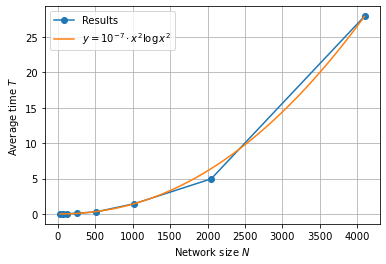

In [32]:
number_of_nodes_list = [2**i for i in range(5, 13)]
avg_time_list = [
    0.0014979839324951172,
    0.0014979839324951172,
    0.02460862398147583,
    0.09736089706420899,
    0.29047956466674807,
    1.4498965263366699,
    4.9504564762115475,
    27.92044311761856
]
plt.plot(number_of_nodes_list, avg_time_list, label='Results', marker='o')
x = np.arange(2**5, 2**12)
y = x**2 * np.log(x**2) * 1e-7
plt.plot(x, y, label='$y = 10^{-7}\cdot x^2\log x^2$')
plt.xlabel('Network size $N$')
plt.ylabel('Average time $T$')
plt.legend()
plt.grid()
plt.savefig('result.pdf')